# HW3：房产租售价比爬取、预测
### Author：马雨翔
### Date：2025-10-13
### 学号：2022201791

## 1 爬取数据

### 1.1 导入库以及定义函数

In [171]:
# 第一部分：爬取网页信息

# 导入需要的库
from selenium import webdriver #Selenium 的核心组件，用来启动浏览器并与网页进行交互。
from selenium.webdriver.edge.service import Service #导入 Edge 浏览器的服务模块，管理 Edge 浏览器的驱动。
from selenium.webdriver.edge.options import Options  #用于设置 Edge 浏览器的选项（例如，无头模式、代理等）
from webdriver_manager.microsoft import EdgeChromiumDriverManager #自动下载和管理 Microsoft Edge 的驱动程序
from selenium.webdriver.common.by import By #用于定位网页元素的方式（例如，通过 ID、CSS选择器、类名、XPath 等）
from selenium.webdriver.support.ui import WebDriverWait #导入 WebDriverWait 类，用于设置等待时间，等待某个元素出现
from selenium.webdriver.support import expected_conditions as EC #导入 expected_conditions (EC) 模块，它提供了与元素条件相关的常见方法（如元素可见性、元素可点击等）
from selenium.common.exceptions import TimeoutException, NoSuchElementException #导入常见的异常处理类。TimeoutException 是等待时间超时时抛出的异常，NoSuchElementException 是找不到元素时抛出的异常
from selenium.webdriver.common.keys import Keys #导入 Keys 类，用于模拟键盘按键操作（如回车、删除等）
import time #导入时间模块，主要用于控制时间延迟
import pandas as pd #导入 Pandas 库，用于数据处理和分析
import numpy as np #导入 NumPy 库，用于数值计算和数组操作
import os #导入操作系统模块，主要用于文件和目录操作
from pathlib import Path
import random #导入随机数模块，主要用于生成随机数

In [172]:
# 关闭小广告
def close_advertisement(driver):
    # 等待 2 秒，直到网页加载完成
    driver.implicitly_wait(2)
    # 关闭页面弹出广告
    try:
        close_button = driver.find_element(By.CLASS_NAME, "icon-close")  # 使用 class name 定位关闭按钮
        close_button.click()  # 点击关闭按钮
    except NoSuchElementException:
        print("No pop-up ad found.")  # 如果没有找到弹出广告，打印信息

In [173]:
# 浏览器打开 URL 的函数
def open_url(url):
    # 配置 Edge 浏览器
    options = Options()
    # options.add_argument("--headless")  # 无头模式（如果不需要浏览器界面，可以使用）

    # 启动浏览器
    driver = webdriver.Edge(options=options)
    
    # 打开目标网页
    driver.get(url)
    print(f"打开网页: {url}")
    
    # 调用关闭广告的函数
    close_advertisement(driver)
    
    return driver  # 返回浏览器实例，以便进一步操作

In [174]:
# 装作是个人
def human_sleep(min_s=1.5, max_s=4.0):
    """随机延时，模拟人类操作间隔"""
    t = random.uniform(min_s, max_s)
    time.sleep(t)

### 1.2 爬取二手房数据

In [175]:
# 打开网页
url_esf = 'https://esf.fang.com/' #二手房
driver = open_url(url_esf)

打开网页: https://esf.fang.com/
No pop-up ad found.


In [176]:
# 定位输入框并填写内容(二手房)——这一操作可以拓展为用户输入
input_box = driver.find_element(By.ID, "input_keyw1")  # 使用 ID 定位
input_box.clear()  # 清空输入框的内容（如果有默认值）
input_box.send_keys('上地')  # 填充负责地区名称
input_box.send_keys(Keys.RETURN) # 模拟按下回车键

In [177]:
# 爬取前20页
pager = 0

# 创建一个空的 DataFrame 用来存储数据
columns = ["title", "room_type", "area", "community_info", "address_info", "total_price", "avg_price"]
data_esf = []

while pager < 20:
    pager += 1
    
    table = driver.find_element(By.CSS_SELECTOR, "body div.main1200.clearfix div.main945.floatl div.shop_list.shop_list_4")  # 使用 class name 定位
    table.text  # 获取表格的文本内容
    # print(table.get_attribute("outerHTML"))

    # 获取所有行
    rows = table.find_elements(By.TAG_NAME, "dl")
    for row in rows:
        # 提取房源标题
        title = row.find_element(By.CSS_SELECTOR, 'dd h4.clearfix a span.tit_shop').text.strip()
        # print(title)

        # 提取房屋类型、面积、楼层、朝向、建筑年份等信息
        house_info = row.find_element(By.CSS_SELECTOR, 'dd p.tel_shop').text.strip()
        # print(house_info)
        # 使用分隔符 " | " 来分割不同的信息
        info_parts = [part.strip() for part in house_info.split("|")]
        # 提取具体信息，假设顺序固定
        room_type = info_parts[0]  # 2室2厅
        area = info_parts[1]  # 95.67㎡

        # 提取小区名和详细地址
        community_info = row.find_element(By.CSS_SELECTOR, 'dd p.add_shop a').text.strip()
        # print(community_info)
        address_info = row.find_element(By.CSS_SELECTOR, 'dd p.add_shop span').text.strip()
        # print(address_info)

        # 提取总价和单价
        total_price_info = row.find_element(By.CSS_SELECTOR, 'dd.price_right span.red b').text.strip()
        # print(total_price_info)
        avg_price_info = row.find_element(By.CSS_SELECTOR, 'dd.price_right span:nth-child(2)').text.strip()
        # print(avg_price_info)

        # 将提取到的数据添加到 data 列表
        data_esf.append([title, room_type, area, community_info, address_info, total_price_info, avg_price_info])
    
    # 在操作前调用 human_sleep，模拟人类操作
    human_sleep(1.0, 3.0)  # 这会随机等待 1-3 秒之间

    # 翻页器（显式等待） 
    # 等待直到 "下一页" 链接可点击
    next_page_link = WebDriverWait(driver, 1).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, "body div.main1200.clearfix div.main945.floatl div.page_box div.page_al p.last a"))
    )
    next_page_link.click() # 点击 "下一页"

driver.quit()  # 关闭浏览器

In [178]:
# 数据清洗



# 将数据转化为 Pandas DataFrame
df_esf = pd.DataFrame(data_esf, columns=columns)
df_esf.to_parquet('shangdi_esf_raw.parquet', engine='pyarrow')

# 去除 `area` 列中的 `㎡`
df_esf['area'] = df_esf['area'].str.replace('㎡', '', regex=False)

# 去除 `avg_price` 中的 `元/㎡`，并修改列名为 `avg_price(元/m2)`
df_esf['avg_price'] = df_esf['avg_price'].str.replace('元/㎡', '', regex=False)
df_esf.rename(columns={'avg_price': 'avg_price(元/m2)'}, inplace=True)

# 保存为 Parquet 文件
df_esf.to_parquet('shangdi_esf.parquet', engine='pyarrow')

# 查看前10行数据
df_esf.head(10)

,title,room_type,area,community_info,address_info,total_price,avg_price(元/m2)
0,"双地铁昌平线8号线朱辛庄,央企中海开发。通勤海淀,西三旗上地",4室2厅,145,中海寰宇未来,回龙观 中海寰宇未来,888,61241
1,"北七家未来科学城,精装现房,刚需盘,通勤海淀,西三旗,上地",4室2厅,143,金辰府,北七家 北七家镇政府正南,578,40419
2,海淀西北旺 弧形大阳台 南北通透 人车分流 马连洼 上地,2室1厅,106.18,保利西山林语,西北旺 (海淀)保利西山林语别墅,510,48031
3,新增好房 客厅明亮 南北通透三居室 光线充足视野好,3室2厅,125.3,上地西里,上地 上地大厦西侧上地西里小区内,1099,87709
4,(客户0)上第moma 3室2厅 146.25平 南北精装,3室2厅,146.25,上第MOMA,上地 (海淀)安宁庄西路,1068,73025
5,"上地佳园,两梯两户,双卧朝南,满五,不临街",3室2厅,149.73,上地佳园,上地 上地东路与上地南路交汇处北行340米路东,1950,130234
6,4室2厅上第MOMA,4室2厅,191,上第MOMA,上地 (海淀)安宁庄西路,1260,65968
7,1室1厅上第MOMA,1室1厅,108.82,上第MOMA,上地 (海淀)安宁庄西路,698,64142
8,"地铁,中关村生命科学园,精装全户型曾宋,沙河通勤海淀,上地",2室1厅,77,龙湖·观萃,沙河 中关村生命科学园(定泗路北约100米),412,53506
9,3室2厅当代城市家园,3室2厅,142.88,当代城市家园,上地 安宁庄西路9号,990,69288


### 1.3 爬取租房数据

In [179]:
# 打开网页
url_zf = 'https://zu.fang.com/' #租房租金
driver = open_url(url_zf)

打开网页: https://zu.fang.com/
No pop-up ad found.


In [180]:
# 定位输入框并填写内容(二手房)——这一操作可以拓展为用户输入
input_box = driver.find_element(By.ID, "input_key")  # 使用 ID 定位
input_box.clear()  # 清空输入框的内容（如果有默认值）
input_box.send_keys('上地')  # 填充负责地区名称

search_button = driver.find_element(By.ID, "rentid_39")
search_button.click()

In [181]:
# 爬取前20页
pager = 0

# 创建一个空的 DataFrame 用来存储数据
columns = ["title", "room_type", "area", "community_info", "rent_price"]
data_zf = []

while pager < 20:  # 假设 get_pages 是一个变量，表示总页数
    pager += 1
    
    table = driver.find_element(By.CSS_SELECTOR, "#listBox > div.houseList")
    table.text  # 获取表格的文本内容
    # print(table.get_attribute("outerHTML"))

    # 获取所有行
    rows = table.find_elements(By.TAG_NAME, "dl")
    for row in rows:
        # 提取房源标题
        title = row.find_element(By.CSS_SELECTOR, 'dd.info.rel p.title a').text.strip()
        # print(title)

        # 提取房屋类型、面积、楼层、朝向、建筑年份等信息
        house_info = row.find_element(By.CSS_SELECTOR, 'dd.info.rel p.font15.mt12.bold').text.strip()
        # print(house_info)
        # 使用分隔符 " | " 来分割不同的信息
        info_parts = [part.strip() for part in house_info.split("|")]
        # 具体提取信息
        # rent_type = info_parts[0].strip()  # "整租"
        room_type = info_parts[1].strip()  # "4室3厅"
        area = info_parts[2].strip()  # "314㎡"
        # orientation = info_parts[3].strip()  # "朝南北"

        # 提取小区名
        community_info = driver.find_element(
            By.CSS_SELECTOR, 'p.gray6.mt12#rentid_D09_14_06'
        ).find_elements(By.TAG_NAME, 'a')[-1].text.strip()  # 获取最后一个 <a> 标签的文本

        # 提取租金
        rent_price = row.find_element(By.CSS_SELECTOR, 'dd.info.rel div.moreInfo p span').text.strip()
        # print(rent_price)

        # 将提取到的数据添加到 data 列表
        data_zf.append([title, room_type, area, community_info, rent_price])

    # 在操作前调用 human_sleep，模拟人类操作
    human_sleep(1.0, 3.0)  # 这会随机等待 1-3 秒之间


    # 翻页器（显式等待）
    try:
        # 第二页及之后，使用 nth-child(8)，第一页使用 nth-child(7)
        if pager == 1:
            next_page_button = WebDriverWait(driver, 1).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, "#rentid_D10_01 > a:nth-child(7)"))
            )
        else:
            next_page_button = WebDriverWait(driver, 1).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, "#rentid_D10_01 > a:nth-child(8)"))
            )
        
        # 确认按钮文本是“下一页”
        if next_page_button.text.strip() == "下一页":
            next_page_button.click()  # 点击“下一页”
            print(f"成功翻到第 {pager} 页")
        else:
            print(f"第 {pager} 页的按钮不是'下一页'，跳出循环")
            break  # 如果按钮文本不是“下一页”，退出循环

    except TimeoutException:
        print(f"第 {pager} 页未找到“下一页”按钮，可能是已经是最后一页了")
        break  # 如果没有找到“下一页”按钮，退出循环

driver.quit()  # 关闭浏览器

成功翻到第 1 页
成功翻到第 2 页
成功翻到第 3 页
成功翻到第 4 页
成功翻到第 5 页
成功翻到第 6 页
成功翻到第 7 页
成功翻到第 8 页
成功翻到第 9 页
成功翻到第 10 页
成功翻到第 11 页
成功翻到第 12 页
成功翻到第 13 页
成功翻到第 14 页
成功翻到第 15 页
第 16 页的按钮不是'下一页'，跳出循环


In [182]:
# 数据清洗

# 将数据转化为 Pandas DataFrame
df_zf = pd.DataFrame(data_zf, columns=columns)
df_zf.to_parquet('shangdi_zf_raw.parquet', engine='pyarrow')

# 去除 `area` 列中的 `㎡`，并修改列名为 `area(m2)`
df_zf['area'] = df_zf['area'].str.replace('㎡', '', regex=False)

# 去除 `rent_price` 中的 `元/月`
df_zf['rent_price'] = df_zf['rent_price'].str.replace('元/月', '', regex=False)

# 保存为 Parquet 文件
df_zf.to_parquet('shangdi_zf.parquet', engine='pyarrow')

# 查看尾120行数据
df_zf.tail(120)

,title,room_type,area,community_info,rent_price
830,整租·马连洼·紫城嘉园·2室,2室1厅,75,上地东里,8800
831,整租·海淀嘉郡 2室1厅 南,2室1厅,85,上地东里,4700
832,整租·海淀嘉郡 2室1厅 南,2室1厅,85,上地东里,4800
833,整租·西山公馆 2室1厅 南,2室1厅,77,上地东里,10500
834,整租·怡美家园 4室2厅 南/北,4室2厅,169,上地东里,14500
...,...,...,...,...,...
945,整租·清河·橡林郡·3室,3室2厅,120,当代城市家园,14800
946,整租·上地·上地东里·3室,3室2厅,150,当代城市家园,15500
947,整租·橡林郡3室2厅,3室2厅,119,当代城市家园,15500
948,整租·海淀嘉郡 2室1厅 南/北,2室1厅,80,当代城市家园,4800


## 2 数据可视化以及回归模型

### 2.1 导入库，合并数据以及定义函数

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### 2.1.1 数据清洗

In [184]:
# 处理数据 1 上地 售价

# 读入数据
shangdi_esf = pd.read_parquet('shangdi_esf.parquet', engine ='pyarrow')
# shangdi_esf.info() #查看数据框条数
# print('\n')

# 删除重复的行，保留第一次出现的行
shangdi_esf_del = shangdi_esf.drop_duplicates()
# 查看数据框条数
# shangdi_esf_del.info()
# 查看空缺值
# shangdi_esf_del.isnull().sum() # 没有空缺值了

shangdi_esf_del = shangdi_esf_del.apply(pd.to_numeric, errors='coerce')
shangdi_esf_del['price/m2'] = shangdi_esf_del['total_price'] * 10000 / shangdi_esf_del['area']
shangdi_esf_del = shangdi_esf_del[['area', 'price/m2']]

# 创建新列并赋值
shangdi_esf_del['is_xierqi'] = 0
shangdi_esf_del['is_xisanqi'] = 0
shangdi_esf_del['is_qinghe'] = 0

shangdi_esf_del.head(10)

,area,price/m2,is_xierqi,is_xisanqi,is_qinghe
0,145.00,61241.379310,0,0,0
1,143.00,40419.580420,0,0,0
2,106.18,48031.644377,0,0,0
3,125.30,87709.497207,0,0,0
4,146.25,73025.641026,0,0,0
5,149.73,130234.421960,0,0,0
6,191.00,65968.586387,0,0,0
7,108.82,64142.620842,0,0,0
8,77.00,53506.493506,0,0,0
9,142.88,69288.913774,0,0,0


In [185]:
# 处理数据 2 西二旗 售价
# 读入数据
xierqi_esf = pd.read_parquet('xierqi_esf.parquet', engine ='pyarrow')
# xierqi_esf.info() #查看数据框条数
# print('\n')
# 删除重复的行
xierqi_esf_del = xierqi_esf.drop_duplicates() # 发现只有567条
xierqi_esf_del = xierqi_esf_del[['area', 'price/万']]
# 查看数据框条数
# xierqi_esf_del.info()

# xisanqi_esf_del.isnull().sum()

# 计算价格 + 地点虚拟变量
xierqi_esf_del['price/m2'] = xierqi_esf_del['price/万'] * 10000 / xierqi_esf_del['area']
# 创建新列并赋值
xierqi_esf_del['is_xierqi'] = 1
xierqi_esf_del['is_xisanqi'] = 0
xierqi_esf_del['is_qinghe'] = 0

# 只保留指定的列
xierqi_esf_del = xierqi_esf_del[['area', 'price/m2', 'is_xierqi', 'is_xisanqi', 'is_qinghe']]

xierqi_esf_del.head(10)

,area,price/m2,is_xierqi,is_xisanqi,is_qinghe
0,88.49,46332.918974,1,0,0
1,225.44,68266.501065,1,0,0
2,291.00,73883.161512,1,0,0
3,294.70,93654.563963,1,0,0
4,153.00,99346.405229,1,0,0
5,291.00,73883.161512,1,0,0
6,182.02,85155.477420,1,0,0
7,291.00,73883.161512,1,0,0
8,294.70,93654.563963,1,0,0
9,88.49,55938.524127,1,0,0


In [186]:
# 处理数据 3 西三旗 售价
# 读入数据
xisanqi_esf = pd.read_parquet('xisanqi_esf.parquet', engine ='pyarrow')
# xisanqi_esf.info() #查看数据框条数
# print('\n')
# 删除重复的行
xisanqi_esf_del = xisanqi_esf.drop_duplicates()
xisanqi_esf_del = xisanqi_esf_del[['price', 'area']]
xisanqi_esf_del.rename(columns={'price': 'total_price'}, inplace=True)
# 查看数据框条数
# xisanqi_esf_del.info() 

# 计算价格 + 地点虚拟变量
xisanqi_esf_del['price/m2'] = xisanqi_esf_del['total_price'] * 10000 / xisanqi_esf_del['area']
# 创建新列并赋值
xisanqi_esf_del['is_xierqi'] = 0
xisanqi_esf_del['is_xisanqi'] = 1
xisanqi_esf_del['is_qinghe'] = 0

# 只保留指定的列
xisanqi_esf_del = xisanqi_esf_del[['area', 'price/m2', 'is_xierqi', 'is_xisanqi', 'is_qinghe']]

xisanqi_esf_del.head(10)

,area,price/m2,is_xierqi,is_xisanqi,is_qinghe
0,115.00,53913.043478,0,1,0
1,139.00,61870.503597,0,1,0
2,206.89,79172.507129,0,1,0
3,160.12,73007.744192,0,1,0
4,101.62,62782.916749,0,1,0
5,75.54,57850.145618,0,1,0
6,89.49,58107.051067,0,1,0
7,178.34,54951.216777,0,1,0
8,139.20,65014.367816,0,1,0
9,128.52,83255.524432,0,1,0


In [187]:
# 处理数据 4 清河 售价
# 读入数据
qinghe_esf = pd.read_parquet('qinghe_esf.parquet', engine ='pyarrow')
# qinghe_esf.info() #查看数据框条数
# print('\n')
# 删除重复的行
qinghe_esf_del = qinghe_esf.drop_duplicates()
# 查看数据框条数
# qinghe_esf_del.info() 

# 计算价格 + 地点虚拟变量
qinghe_esf_del = qinghe_esf_del.apply(pd.to_numeric, errors='coerce')
qinghe_esf_del['price/m2'] = qinghe_esf_del['total_price'] * 10000 / qinghe_esf_del['area']

# 创建新列并赋值
qinghe_esf_del['is_xierqi'] = 0
qinghe_esf_del['is_xisanqi'] = 0
qinghe_esf_del['is_qinghe'] = 1

# 只保留指定的列
qinghe_esf_del = qinghe_esf_del[['area', 'price/m2', 'is_xierqi', 'is_xisanqi', 'is_qinghe']]

qinghe_esf_del.head(10)

,area,price/m2,is_xierqi,is_xisanqi,is_qinghe
0,125.54,100764.696511,0,0,1
1,166.00,71987.951807,0,0,1
2,180.00,80555.555556,0,0,1
3,97.68,112407.862408,0,0,1
4,237.70,117795.540597,0,0,1
5,100.58,128057.267846,0,0,1
6,144.37,130220.960033,0,0,1
7,191.51,101822.359146,0,0,1
8,237.70,119057.635675,0,0,1
9,99.37,92382.006642,0,0,1


In [188]:

# 读入数据 1 上地 租金
shangdi_zf = pd.read_parquet('shangdi_zf.parquet', engine ='pyarrow')
# shangdi_zf.info() #查看数据框条数
# print('\n')
# 删除重复的行
shangdi_zf_del = shangdi_zf.drop_duplicates() # 发现只有567条
# 查看数据框条数
# shangdi_zf_del.info() 

shangdi_zf_del = shangdi_zf_del.apply(pd.to_numeric, errors='coerce')
shangdi_zf_del['rent/m2'] = shangdi_zf_del['rent_price'] / shangdi_zf_del['area']
shangdi_zf_del = shangdi_zf_del[['area', 'rent/m2']]

# 创建新列并赋值
shangdi_zf_del['is_xierqi'] = 0
shangdi_zf_del['is_xisanqi'] = 0
shangdi_zf_del['is_qinghe'] = 0

shangdi_zf_del.head(10)


,area,rent/m2,is_xierqi,is_xisanqi,is_qinghe
0,314,81.210191,0,0,0
1,125,88.000000,0,0,0
2,136,94.852941,0,0,0
3,106,113.207547,0,0,0
4,114,92.105263,0,0,0
5,61,118.032787,0,0,0
6,97,92.783505,0,0,0
7,64,85.937500,0,0,0
8,69,108.695652,0,0,0
9,59,128.813559,0,0,0


In [189]:
# 读入数据 2 西二旗 租金
xierqi_zf = pd.read_parquet('xierqi_zf.parquet', engine ='pyarrow')
# xierqi_zf.info() #查看数据框条数
# print('\n')
# 删除重复的行
xierqi_zf_del = xierqi_zf.drop_duplicates() # 发现只有567条
# 查看数据框条数
# xierqi_zf_del.info() 

xierqi_zf_del = xierqi_zf_del.apply(pd.to_numeric, errors='coerce')
xierqi_zf_del['rent/m2'] = xierqi_zf_del['rent/元'] / shangdi_zf_del['area']
xierqi_zf_del = xierqi_zf_del[['area', 'rent/m2']]

# 创建新列并赋值
xierqi_zf_del['is_xierqi'] = 1
xierqi_zf_del['is_xisanqi'] = 0
xierqi_zf_del['is_qinghe'] = 0

xierqi_zf_del.head(10)

,area,rent/m2,is_xierqi,is_xisanqi,is_qinghe
0,18.0,7.643312,1,0,0
1,187.0,127.200000,1,0,0
2,107.0,69.852941,1,0,0
3,187.0,150.000000,1,0,0
4,152.0,114.035088,1,0,0
5,143.0,196.721311,1,0,0
6,107.0,97.938144,1,0,0
7,138.0,187.500000,1,0,0
8,233.0,405.797101,1,0,0
9,268.0,813.559322,1,0,0


In [190]:
# 读入数据 3 西三旗 租金
xisanqi_zf = pd.read_parquet('xisanqi_zf.parquet', engine ='pyarrow')
# xisanqi_zf.info() #查看数据框条数
# print('\n')
# 删除重复的行
xisanqi_zf_del = xisanqi_zf.drop_duplicates()
# 查看数据框条数
# xisanqi_zf_del.info() 

xisanqi_zf_del = xisanqi_zf_del.apply(pd.to_numeric, errors='coerce')
xisanqi_zf_del['rent/m2'] = xisanqi_zf_del['price'] / xisanqi_zf_del['area']

xisanqi_zf_del = xisanqi_zf_del[['area', 'rent/m2']]

# 创建新列并赋值
xisanqi_zf_del['is_xierqi'] = 0
xisanqi_zf_del['is_xisanqi'] = 1
xisanqi_zf_del['is_qinghe'] = 0

xisanqi_zf_del.head(10)


,area,rent/m2,is_xierqi,is_xisanqi,is_qinghe
0,36.0,97.222222,0,1,0
1,242.0,78.512397,0,1,0
2,190.0,78.947368,0,1,0
3,132.0,112.121212,0,1,0
4,130.0,69.230769,0,1,0
5,99.0,71.717172,0,1,0
6,10.0,140.000000,0,1,0
7,45.0,84.444444,0,1,0
8,100.0,62.000000,0,1,0
9,19.0,105.263158,0,1,0


In [191]:
# 读入数据 4 清河 租金
qinghe_zf = pd.read_parquet('qinghe_zf.parquet', engine ='pyarrow')
# qinghe_zf.info() #查看数据框条数
# print('\n')
# 删除重复的行
qinghe_zf_del = qinghe_zf.drop_duplicates() # 发现只有567条
# 查看数据框条数
# qinghe_zf_del.info() 

qinghe_zf_del = qinghe_zf_del.apply(pd.to_numeric, errors='coerce')
qinghe_zf_del['rent/m2'] = qinghe_zf_del['rent'] / qinghe_zf_del['area']

qinghe_zf_del = qinghe_zf_del[['area', 'rent/m2']]

# 创建新列并赋值
qinghe_zf_del['is_xierqi'] = 0
qinghe_zf_del['is_xisanqi'] = 0
qinghe_zf_del['is_qinghe'] = 1

qinghe_zf_del.head(10)


,area,rent/m2,is_xierqi,is_xisanqi,is_qinghe
0,85.0,80.000000,0,0,1
1,40.0,125.000000,0,0,1
2,18.0,111.111111,0,0,1
3,20.0,100.000000,0,0,1
4,10.0,150.000000,0,0,1
5,25.0,144.000000,0,0,1
6,12.0,150.000000,0,0,1
7,47.0,106.382979,0,0,1
8,186.0,241.935484,0,0,1
9,158.0,91.772152,0,0,1


#### 2.1.2 数据合并

In [192]:
# 将二手房合并成一个大数据框
big_factory_esf = pd.concat([shangdi_esf_del, xierqi_esf_del, xisanqi_esf_del, qinghe_esf_del], ignore_index=True)

# 查看是否有空缺值
big_factory_esf.isnull().sum()

# 保存
big_factory_esf.to_parquet('big_factory_esf.parquet', engine='pyarrow')

# 查看合并后的数据框
big_factory_esf.head(10)

,area,price/m2,is_xierqi,is_xisanqi,is_qinghe
0,145.00,61241.379310,0,0,0
1,143.00,40419.580420,0,0,0
2,106.18,48031.644377,0,0,0
3,125.30,87709.497207,0,0,0
4,146.25,73025.641026,0,0,0
5,149.73,130234.421960,0,0,0
6,191.00,65968.586387,0,0,0
7,108.82,64142.620842,0,0,0
8,77.00,53506.493506,0,0,0
9,142.88,69288.913774,0,0,0


In [193]:
# 租房数据合并
big_factory_zf = pd.concat([shangdi_zf_del, xierqi_zf_del, xisanqi_zf_del, qinghe_zf_del], ignore_index=True)
big_factory_zf.isnull().sum()
big_factory_zf.to_parquet('big_factory_zf.parquet', engine='pyarrow')
big_factory_zf.head(10)

,area,rent/m2,is_xierqi,is_xisanqi,is_qinghe
0,314.0,81.210191,0,0,0
1,125.0,88.000000,0,0,0
2,136.0,94.852941,0,0,0
3,106.0,113.207547,0,0,0
4,114.0,92.105263,0,0,0
5,61.0,118.032787,0,0,0
6,97.0,92.783505,0,0,0
7,64.0,85.937500,0,0,0
8,69.0,108.695652,0,0,0
9,59.0,128.813559,0,0,0


### 2.2 描述性统计

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

    region    N          mean        median            sd           min  \
0   qinghe  390  88412.830590  91741.838584  28097.007719  39943.191905   
1  shangdi  564  89422.283875  84134.615385  24840.718215  32781.456954   
2   xierqi  491  66414.663482  64790.313527  17546.066891  27182.744866   
3  xisanqi  782  58491.422239  57970.493541  15246.193572  28357.668638   

             max  
0  176525.723808  
1  175519.630485  
2  121592.866552  
3  146602.999078   



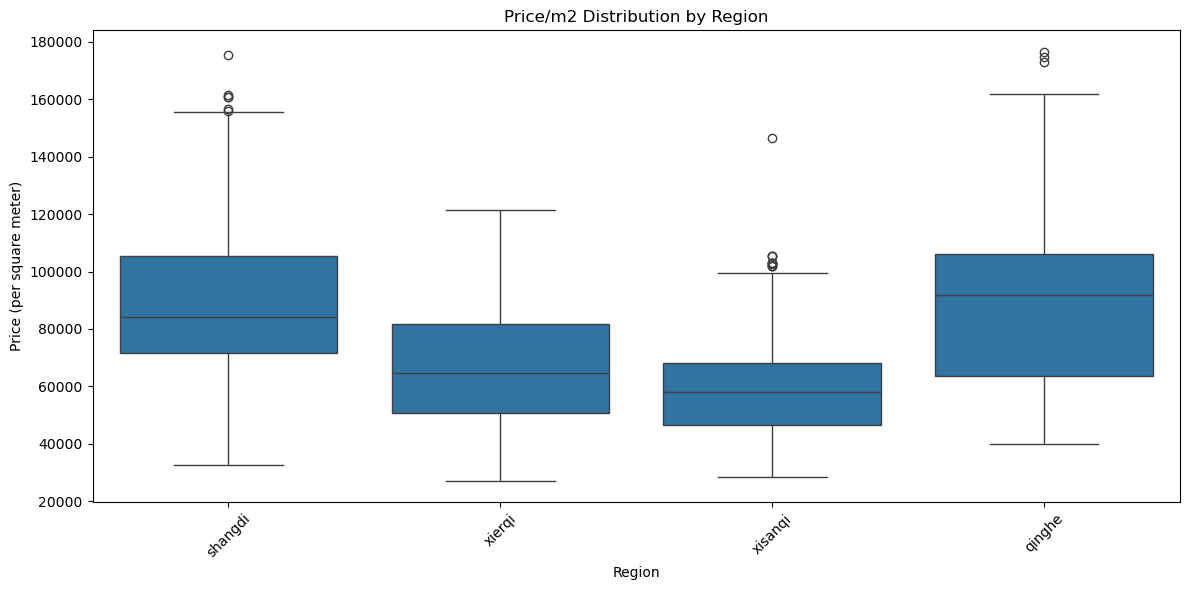

In [4]:
# 加载 二手房 数据
big_factory_esf = pd.read_parquet('big_factory_esf.parquet')

# (1) 创建地区列，基于 is_xierqi, is_xisanqi, is_qinghe
def assign_region(row):
    if row['is_xierqi'] == 1:
        return 'xierqi'
    elif row['is_xisanqi'] == 1:
        return 'xisanqi'
    elif row['is_qinghe'] == 1:
        return 'qinghe'
    else:
        return 'shangdi'  # 三个都为0时是上地


big_factory_esf['region'] = big_factory_esf.apply(assign_region, axis=1)
# 保存修改后的 big_factory_esf 数据框为 Parquet 文件
big_factory_esf.to_parquet('big_factory_esf.parquet')


# (2) 计算每个地区的统计量
stats = big_factory_esf.groupby('region')['price/m2'].agg(
    N='count',
    mean='mean',
    median='median',
    sd='std',
    min='min',
    max='max'
).reset_index()


print(stats, '\n')


# (3) 绘制箱型图
plt.figure(figsize=(12, 6))

# 使用 Seaborn 绘制箱型图
sns.boxplot(data=big_factory_esf, x='region', y='price/m2', order=['shangdi', 'xierqi', 'xisanqi', 'qinghe'])

plt.title('Price/m2 Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Price (per square meter)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

    region    N        mean      median          sd        min          max
0   qinghe  640  113.262410   96.427432  178.043910  15.619835  4469.273743
1  shangdi  731  109.168641  104.273504   33.318784  25.000000   248.000000
2   xierqi  157  222.710141  122.033898  225.635973   7.643312  1150.000000
3  xisanqi  645   90.429271   81.189655   30.281590   1.000000   254.545455 



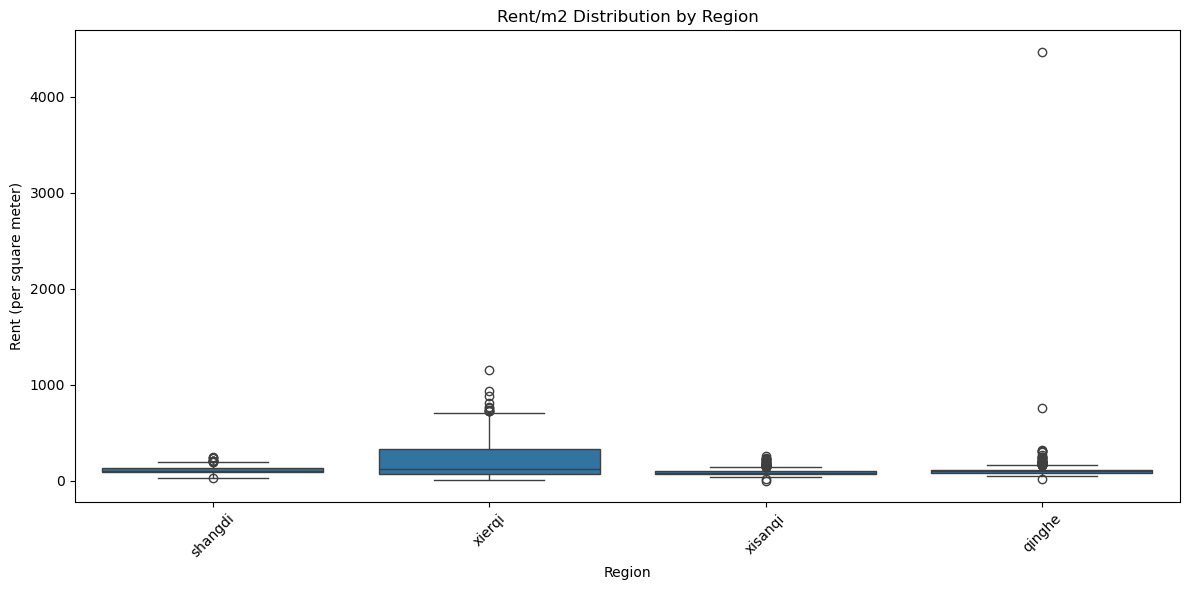

In [196]:
# 加载 租房 数据
big_factory_zf = pd.read_parquet('big_factory_zf.parquet')

# (1) 创建地区列，基于 is_xierqi, is_xisanqi, is_qinghe
def assign_region(row):
    if row['is_xierqi'] == 1:
        return 'xierqi'
    elif row['is_xisanqi'] == 1:
        return 'xisanqi'
    elif row['is_qinghe'] == 1:
        return 'qinghe'
    else:
        return 'shangdi'  # 三个都为0时是上地


big_factory_zf['region'] = big_factory_zf.apply(assign_region, axis=1)

# 保存修改后的 big_factory_zf 数据框为 Parquet 文件
big_factory_zf.to_parquet('big_factory_zf.parquet')


# (2) 计算每个地区的统计量
stats = big_factory_zf.groupby('region')['rent/m2'].agg(
    N='count',
    mean='mean',
    median='median',
    sd='std',
    min='min',
    max='max'
).reset_index()


print(stats, '\n')


# (3) 绘制箱型图
plt.figure(figsize=(12, 6))

# 使用 Seaborn 绘制箱型图
sns.boxplot(data=big_factory_zf, x='region', y='rent/m2', order=['shangdi', 'xierqi', 'xisanqi', 'qinghe'])

plt.title('Rent/m2 Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Rent (per square meter)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.3 题1：计算中位数

    region      price_m2     rent_m2  price_rent_ratio
0   qinghe  91741.838584   96.427432        951.408085
1  shangdi  84134.615385  104.273504        806.864754
2   xierqi  64790.313527  122.033898        530.920625
3  xisanqi  57970.493541   81.189655        714.013299


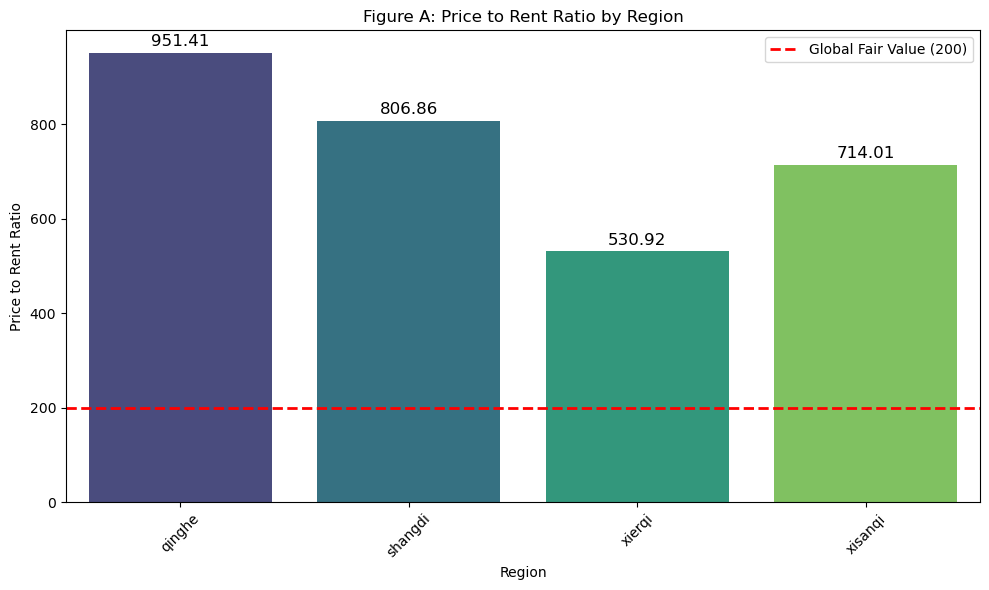

In [8]:

# 加载 二手房 数据
big_factory_esf = pd.read_parquet('big_factory_esf.parquet')
# 加载 租房 数据
big_factory_zf = pd.read_parquet('big_factory_zf.parquet')

medians_price_rent = big_factory_esf.groupby('region').agg(
    price_m2 = ('price/m2', 'median')
).reset_index()
# print(medians_price)

medians_rent = big_factory_zf.groupby('region').agg(
    rent_m2 = ('rent/m2', 'median')
).reset_index()
# print(medians_rent)


# 直接计算 price_rent_ratio
medians_price_rent['rent_m2'] = medians_rent['rent_m2']
medians_price_rent['price_rent_ratio'] = medians_price_rent['price_m2'] / medians_price_rent['rent_m2']

# 查看结果
print(medians_price_rent)


# 绘制 price_rent_ratio 的柱状图
plt.figure(figsize=(10, 6))

# 创建柱状图
ax = sns.barplot(data=medians_price_rent, x='region', y='price_rent_ratio', hue='region', palette='viridis', legend=False)

# 在每个柱子上方添加数值
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',  # 显示柱子的高度，即 price_rent_ratio 值
                (p.get_x() + p.get_width() / 2., p.get_height()),  # 设置位置
                ha='center', va='center',  # 水平和垂直居中
                xytext=(0, 8),  # 微调文本位置，使其稍微离开柱顶
                textcoords='offset points',  # 使用偏移坐标系
                fontsize=12, color='black')  # 设置字体大小和颜色

# 添加红色的虚线
ax.axhline(y=200, color='red', linestyle='--', linewidth=2, label='Global Fair Value (200)')

plt.title('Figure A: Price to Rent Ratio by Region')
plt.xlabel('Region')
plt.legend()
plt.ylabel('Price to Rent Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2.4 题2：线性回归

In [198]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [199]:
import pandas as pd

def save_regression_results(model, name, output_file):
    """
    提取回归模型的统计量，并将回归结果保存到文件中。

    参数:
    - model: 已拟合的回归模型 (statsmodels OLS 模型)
    - name: 模型名称
    - output_file: 结果文件的保存路径 (默认 'regression_results.parquet')
    """
    # (1) 提取模型统计量
    n_samples = model.nobs  # 样本量
    r2 = model.rsquared  # R^2 值

    # 变量的系数和显著性
    coefficients = model.params  # 回归系数
    p_values = model.pvalues  # 每个系数的 p-value

    # (2) 根据 p-value 添加显著性星号
    def get_significance(p_value):
        if p_value < 0.01:
            return '***'
        elif p_value < 0.05:
            return '**'
        elif p_value < 0.10:
            return '*'
        else:
            return 'Not Significant'

    # 创建一个 DataFrame 保存模型结果
    model_results = pd.DataFrame({
        'Model Name': [name] * len(coefficients),  # 每个系数都标注模型名称
        'Variable': coefficients.index,
        'Coefficient': coefficients.values,
        'P-value': p_values.values,
        'Significance': p_values.apply(get_significance),  # 添加显著性列
        'Sample Size (N)': n_samples,
        'R-squared': r2
    })

    # 输出回归结果（可选）
    # print(model_results.tail(10))
    
    # (3) 保存结果到 Parquet 文件
    model_results.to_parquet(output_file, index=False)

    # 可选：打印保存后的结果概览
    # print(f"Model results saved to {output_file}")
    # print(model_results.head())



In [200]:
########### 估计二手房的平米售价

# (1) 加载数据
big_factory_esf = pd.read_parquet('big_factory_esf.parquet')
big_factory_zf = pd.read_parquet('big_factory_zf.parquet')

# (2) 回归分析：对 price/m2 进行回归，使用三个虚拟变量 + area 作为自变量
# 确保数据中没有缺失值
big_factory_esf = big_factory_esf.dropna(subset=['price/m2', 'is_xierqi', 'is_xisanqi', 'is_qinghe', 'area'])

# 自变量 X，包括虚拟变量和 area
X_esf = big_factory_esf[['is_xierqi', 'is_xisanqi', 'is_qinghe', 'area']]  
X_esf = sm.add_constant(X_esf)  # 添加常数项（截距）

# 因变量 y
y = big_factory_esf['price/m2']  

# 建立回归模型
model = sm.OLS(y, X_esf).fit()

# 记录回归结果
save_regression_results(model, 'Linear OLS for price', 'model_Linear OLS for price.parquet')

# 获取回归方程并避免警告
print(f'回归方程：\n price/m2 = {model.params.iloc[0]:.4f} + {model.params.iloc[1]:.4f}*is_xierqi + {model.params.iloc[2]:.4f}*is_xisanqi + {model.params.iloc[3]:.4f}*is_qinghe + {model.params.iloc[4]:.4f}*area')

# 计算 R2
r2 = model.rsquared
print(f'R^2 = {r2:.4f}','\n')

# 输出回归结果
# print(model.summary())  # 输出回归方程和统计信息

# (3) 使用回归模型进行预测
# 提取 big_factory_zf 的自变量
# 确保数据中没有缺失值
big_factory_zf = big_factory_zf.dropna(subset=['rent/m2', 'is_xierqi', 'is_xisanqi', 'is_qinghe', 'area'])
X_zf = big_factory_zf[['is_xierqi', 'is_xisanqi', 'is_qinghe', 'area']]
X_zf = sm.add_constant(X_zf)  # 添加常数项（截距）

# 进行预测
big_factory_zf['price_predicted'] = model.predict(X_zf)
big_factory_zf['p_to_r_predicted'] = big_factory_zf['price_predicted'] / big_factory_zf['rent/m2']

# 创建新的 DataFrame p_to_r，包含 location（region）和 p_to_r_predicted 列
p_to_r = big_factory_zf[['region', 'p_to_r_predicted']]
p_to_r.info()


回归方程：
 price/m2 = 79574.0001 + -24464.7800*is_xierqi + -30703.4588*is_xisanqi + -1659.9307*is_qinghe + 88.6332*area
R^2 = 0.3415 

<class 'pandas.core.frame.DataFrame'>
Index: 2173 entries, 0 to 2328
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   region            2173 non-null   object 
 1   p_to_r_predicted  2173 non-null   float64
dtypes: float64(1), object(1)
memory usage: 50.9+ KB


In [201]:
############ 估计租房租金

# (1) 加载数据
big_factory_esf = pd.read_parquet('big_factory_esf.parquet')
big_factory_zf = pd.read_parquet('big_factory_zf.parquet')

# (2) 回归分析：对 price/m2 进行回归，使用三个虚拟变量 + area 作为自变量
# 确保数据中没有缺失值
big_factory_zf = big_factory_zf.dropna(subset=['rent/m2', 'is_xierqi', 'is_xisanqi', 'is_qinghe', 'area'])

# 自变量 X，包括虚拟变量和 area
X_zf = big_factory_zf[['is_xierqi', 'is_xisanqi', 'is_qinghe', 'area']]  
X_zf = sm.add_constant(X_zf)  # 添加常数项（截距）

# 因变量 y
y = big_factory_zf['rent/m2']

# 建立回归模型
model = sm.OLS(y, X_zf).fit()

# 记录回归结果
save_regression_results(model, 'Linear OLS for rent', 'model_Linear OLS for rent.parquet')

# 获取回归方程并避免警告
print(f'回归方程：\n rent/m2 = {model.params.iloc[0]:.4f} + {model.params.iloc[1]:.4f}*is_xierqi + {model.params.iloc[2]:.4f}*is_xisanqi + {model.params.iloc[3]:.4f}*is_qinghe + {model.params.iloc[4]:.4f}*area')

# 计算 R2
r2 = model.rsquared
print(f'R^2 = {r2:.4f}','\n')

# 输出回归结果
# print(model.summary())  # 输出回归方程和统计信息

# (3) 使用回归模型进行预测
# 提取 big_factory_esf 的自变量
# 确保数据中没有缺失值
big_factory_esf = big_factory_esf.dropna(subset=['price/m2', 'is_xierqi', 'is_xisanqi', 'is_qinghe', 'area'])
X_esf = big_factory_esf[['is_xierqi', 'is_xisanqi', 'is_qinghe', 'area']]
X_esf = sm.add_constant(X_esf)  # 添加常数项（截距）

# 进行预测
big_factory_esf['rent_predicted'] = model.predict(X_esf)
big_factory_esf['p_to_r_predicted'] = big_factory_esf['price/m2'] / big_factory_esf['rent_predicted']

# 向 DataFrame p_to_r 中加入 region 和 p_to_r_predicted 列
# 提取 big_factory_esf 中的 region 和 p_to_r_predicted 列
new_data = big_factory_esf[['region', 'p_to_r_predicted']]
p_to_r = pd.concat([p_to_r, new_data], ignore_index=True)
p_to_r.to_parquet('p_to_r.parquet')

# 查看更新后的 p_to_r
p_to_r.info()


回归方程：
 rent/m2 = 106.0156 + 112.6044*is_xierqi + -18.6764*is_xisanqi + 4.3400*is_qinghe + 0.0391*area
R^2 = 0.0704 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   region            4400 non-null   object 
 1   p_to_r_predicted  4400 non-null   float64
dtypes: float64(1), object(1)
memory usage: 68.9+ KB


    region  p_to_r_predicted
0   qinghe        857.632445
1  shangdi        799.308581
2   xierqi        302.174146
3  xisanqi        656.643972


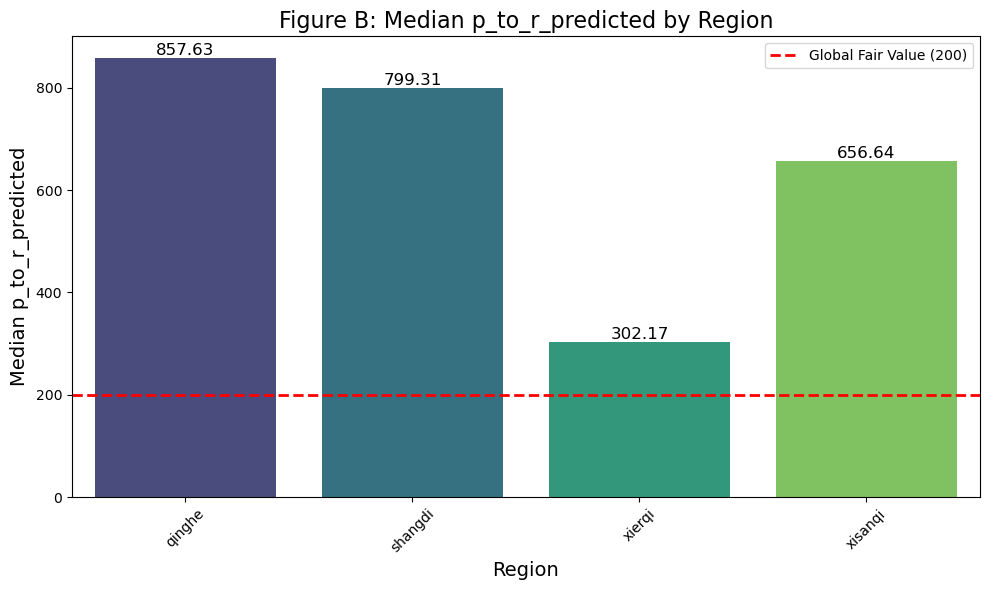

In [9]:
# 计算地区中位数并画图

# 加载 p_to_r.parquet 文件
p_to_r = pd.read_parquet('p_to_r.parquet')

# 计算每个 region 的 p_to_r_predicted 列的中位数
medians = p_to_r.groupby('region')['p_to_r_predicted'].median().reset_index()

# 查看中位数结果
print(medians)



# 使用 seaborn 绘制 bar plot
plt.figure(figsize=(10, 6))  # 保持图形大小不变
ax = sns.barplot(data=medians, x='region', y='p_to_r_predicted', hue='region', palette='viridis', legend=False)

# 在每个条形顶部添加数字
for p in ax.patches:
    height = p.get_height()  # 获取条形的高度（即中位数值）
    # 在条形顶部添加数字，稍微调整位置使其不重叠
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5,  # 小调整，避免与条形重叠
            f'{height:.2f}',  # 显示两位小数
            ha='center', va='bottom', fontsize=12)  # 水平居中，垂直对齐在顶部


# 添加红色的虚线
ax.axhline(y=200, color='red', linestyle='--', linewidth=2, label='Global Fair Value (200)')

# 添加标题和标签
plt.title('Figure B: Median p_to_r_predicted by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.legend()
plt.ylabel('Median p_to_r_predicted', fontsize=14)
plt.xticks(rotation=45)  # 让 x 轴标签倾斜以便显示
plt.tight_layout()  # 确保图形不会被截断

# 显示图形
plt.show()

### 2.5 题3：非线性回归

In [203]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

In [204]:
# 非线性估计 二手房售价

# (1) 加载数据
big_factory_esf = pd.read_parquet('big_factory_esf.parquet')
big_factory_zf = pd.read_parquet('big_factory_zf.parquet')

# (2) 回归分析：对 price/m2 进行回归，使用三个虚拟变量 + area 的非线性项和交互项作为自变量
# 确保数据中没有缺失值
big_factory_esf = big_factory_esf.dropna(subset=['price/m2', 'is_xierqi', 'is_xisanqi', 'is_qinghe', 'area'])

# 自变量 X，包括虚拟变量，area，area^2，log(area) 以及交互项
big_factory_esf['area_squared'] = big_factory_esf['area'] ** 2  # 添加面积的平方项
big_factory_esf['log_area'] = np.log(big_factory_esf['area'])  # 添加面积的对数项

# 交互项：area 与虚拟变量的交互
big_factory_esf['area_is_xierqi'] = big_factory_esf['area'] * big_factory_esf['is_xierqi']
big_factory_esf['area_is_xisanqi'] = big_factory_esf['area'] * big_factory_esf['is_xisanqi']
big_factory_esf['area_is_qinghe'] = big_factory_esf['area'] * big_factory_esf['is_qinghe']

# 交互项：area_squared 与虚拟变量的交互
big_factory_esf['area_squared_is_xierqi'] = big_factory_esf['area_squared'] * big_factory_esf['is_xierqi']
big_factory_esf['area_squared_is_xisanqi'] = big_factory_esf['area_squared'] * big_factory_esf['is_xisanqi']
big_factory_esf['area_squared_is_qinghe'] = big_factory_esf['area_squared'] * big_factory_esf['is_qinghe']

# 自变量 X
X_esf = big_factory_esf[['is_xierqi', 'is_xisanqi', 'is_qinghe', 'area', 'area_squared', 'log_area', 
                         'area_is_xierqi', 'area_is_xisanqi', 'area_is_qinghe',
                         'area_squared_is_xierqi', 'area_squared_is_xisanqi', 'area_squared_is_qinghe']]  
X_esf = sm.add_constant(X_esf)  # 添加常数项（截距）

# 因变量 y
y = big_factory_esf['price/m2']  

# 建立回归模型
model = sm.OLS(y, X_esf).fit()

# 记录回归结果
save_regression_results(model, 'Non-linear OLS for price', 'model_Non-linear OLS for price.parquet')

# 获取回归方程
print(f'回归方程：\n price/m2 = {model.params.iloc[0]:.4f} + {model.params.iloc[1]:.4f}*is_xierqi + {model.params.iloc[2]:.4f}*is_xisanqi + {model.params.iloc[3]:.4f}*is_qinghe + {model.params.iloc[4]:.4f}*area + {model.params.iloc[5]:.4f}*area^2 + {model.params.iloc[6]:.4f}*log(area) + {model.params.iloc[7]:.4f}*area*is_xierqi + {model.params.iloc[8]:.4f}*area*is_xisanqi + {model.params.iloc[9]:.4f}*area*is_qinghe + {model.params.iloc[10]:.4f}*area^2*is_xierqi + {model.params.iloc[11]:.4f}*area^2*is_xisanqi + {model.params.iloc[12]:.4f}*area^2*is_qinghe')

# 计算 R2
r2 = model.rsquared
print(f'R^2 = {r2:.4f}','\n')

# 输出回归结果
# print(model.summary())  # 输出回归方程和统计信息

# (3) 使用回归模型进行预测
# 确保数据中没有缺失值
big_factory_zf = big_factory_zf.dropna(subset=['rent/m2', 'is_xierqi', 'is_xisanqi', 'is_qinghe', 'area'])

# 在 big_factory_zf 中添加相同的非线性项和交互项
big_factory_zf['area_squared'] = big_factory_zf['area'] ** 2
big_factory_zf['log_area'] = np.log(big_factory_zf['area'])

# 交互项：area 与虚拟变量的交互
big_factory_zf['area_is_xierqi'] = big_factory_zf['area'] * big_factory_zf['is_xierqi']
big_factory_zf['area_is_xisanqi'] = big_factory_zf['area'] * big_factory_zf['is_xisanqi']
big_factory_zf['area_is_qinghe'] = big_factory_zf['area'] * big_factory_zf['is_qinghe']

# 交互项：area_squared 与虚拟变量的交互
big_factory_zf['area_squared_is_xierqi'] = big_factory_zf['area_squared'] * big_factory_zf['is_xierqi']
big_factory_zf['area_squared_is_xisanqi'] = big_factory_zf['area_squared'] * big_factory_zf['is_xisanqi']
big_factory_zf['area_squared_is_qinghe'] = big_factory_zf['area_squared'] * big_factory_zf['is_qinghe']

# 自变量 X
X_zf = big_factory_zf[['is_xierqi', 'is_xisanqi', 'is_qinghe', 'area', 'area_squared', 'log_area', 
                       'area_is_xierqi', 'area_is_xisanqi', 'area_is_qinghe',
                       'area_squared_is_xierqi', 'area_squared_is_xisanqi', 'area_squared_is_qinghe']]
X_zf = sm.add_constant(X_zf)  # 添加常数项（截距）

# 进行预测
big_factory_zf['price_predicted_plus'] = model.predict(X_zf)
big_factory_zf['p_to_r_predicted_plus'] = big_factory_zf['price_predicted_plus'] / big_factory_zf['rent/m2']

# 创建新的 DataFrame p_to_r，包含 location（region）和 p_to_r_predicted 列
p_to_r_plus = big_factory_zf[['region', 'p_to_r_predicted_plus']]
p_to_r_plus.info()


回归方程：
 price/m2 = 158442.8442 + -82174.1642*is_xierqi + -73426.3574*is_xisanqi + -87910.8606*is_qinghe + -276.4867*area + 0.9034*area^2 + -11006.6100*log(area) + 717.7902*area*is_xierqi + 515.9402*area*is_xisanqi + 1106.4205*area*is_qinghe + -1.5829*area^2*is_xierqi + -1.0397*area^2*is_xisanqi + -2.5420*area^2*is_qinghe
R^2 = 0.4359 

<class 'pandas.core.frame.DataFrame'>
Index: 2173 entries, 0 to 2328
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   region                 2173 non-null   object 
 1   p_to_r_predicted_plus  2173 non-null   float64
dtypes: float64(1), object(1)
memory usage: 50.9+ KB


In [205]:
############ 非线性估计租房租金

# (1) 加载数据
big_factory_esf = pd.read_parquet('big_factory_esf.parquet')
big_factory_zf = pd.read_parquet('big_factory_zf.parquet')

# (2) 回归分析：对 rent/m2 进行回归，使用三个虚拟变量 + area 的非线性项和交互项作为自变量
# 确保数据中没有缺失值
big_factory_zf = big_factory_zf.dropna(subset=['rent/m2', 'is_xierqi', 'is_xisanqi', 'is_qinghe', 'area'])

# 自变量 X，包括虚拟变量，area，area^2，log(area) 以及交互项
big_factory_zf['area_squared'] = big_factory_zf['area'] ** 2  # 添加面积的平方项
big_factory_zf['log_area'] = np.log(big_factory_zf['area'])  # 添加面积的对数项

# 交互项：area 与虚拟变量的交互
big_factory_zf['area_is_xierqi'] = big_factory_zf['area'] * big_factory_zf['is_xierqi']
big_factory_zf['area_is_xisanqi'] = big_factory_zf['area'] * big_factory_zf['is_xisanqi']
big_factory_zf['area_is_qinghe'] = big_factory_zf['area'] * big_factory_zf['is_qinghe']

# 交互项：area_squared 与虚拟变量的交互
big_factory_zf['area_squared_is_xierqi'] = big_factory_zf['area_squared'] * big_factory_zf['is_xierqi']
big_factory_zf['area_squared_is_xisanqi'] = big_factory_zf['area_squared'] * big_factory_zf['is_xisanqi']
big_factory_zf['area_squared_is_qinghe'] = big_factory_zf['area_squared'] * big_factory_zf['is_qinghe']

# 自变量 X
X_zf = big_factory_zf[['is_xierqi', 'is_xisanqi', 'is_qinghe', 'area', 'area_squared', 'log_area', 
                       'area_is_xierqi', 'area_is_xisanqi', 'area_is_qinghe',
                       'area_squared_is_xierqi', 'area_squared_is_xisanqi', 'area_squared_is_qinghe']]
X_zf = sm.add_constant(X_zf)  # 添加常数项（截距）

# 因变量 y
y = big_factory_zf['rent/m2']

# 建立回归模型
model = sm.OLS(y, X_zf).fit()

# 记录回归结果
save_regression_results(model, 'Non-linear OLS for rent', 'model_Non-linear OLS for rent.parquet')

# 获取回归方程并避免警告
print(f'回归方程：\n rent/m2 = {model.params.iloc[0]:.4f} + {model.params.iloc[1]:.4f}*is_xierqi + {model.params.iloc[2]:.4f}*is_xisanqi + {model.params.iloc[3]:.4f}*is_qinghe + {model.params.iloc[4]:.4f}*area + {model.params.iloc[5]:.4f}*area^2 + {model.params.iloc[6]:.4f}*log(area) + {model.params.iloc[7]:.4f}*area*is_xierqi + {model.params.iloc[8]:.4f}*area*is_xisanqi + {model.params.iloc[9]:.4f}*area*is_qinghe + {model.params.iloc[10]:.4f}*area^2*is_xierqi + {model.params.iloc[11]:.4f}*area^2*is_xisanqi + {model.params.iloc[12]:.4f}*area^2*is_qinghe')

# 计算 R^2
r2 = model.rsquared
print(f'R^2 = {r2:.4f}','\n')

# 输出回归结果
# print(model.summary())  # 输出回归方程和统计信息

# (3) 使用回归模型进行预测
# 确保数据中没有缺失值
big_factory_esf = big_factory_esf.dropna(subset=['price/m2', 'is_xierqi', 'is_xisanqi', 'is_qinghe', 'area'])

# 在 big_factory_esf 中添加相同的非线性项和交互项
big_factory_esf['area_squared'] = big_factory_esf['area'] ** 2
big_factory_esf['log_area'] = np.log(big_factory_esf['area'])

# 交互项：area 与虚拟变量的交互
big_factory_esf['area_is_xierqi'] = big_factory_esf['area'] * big_factory_esf['is_xierqi']
big_factory_esf['area_is_xisanqi'] = big_factory_esf['area'] * big_factory_esf['is_xisanqi']
big_factory_esf['area_is_qinghe'] = big_factory_esf['area'] * big_factory_esf['is_qinghe']

# 交互项：area_squared 与虚拟变量的交互
big_factory_esf['area_squared_is_xierqi'] = big_factory_esf['area_squared'] * big_factory_esf['is_xierqi']
big_factory_esf['area_squared_is_xisanqi'] = big_factory_esf['area_squared'] * big_factory_esf['is_xisanqi']
big_factory_esf['area_squared_is_qinghe'] = big_factory_esf['area_squared'] * big_factory_esf['is_qinghe']

# 自变量 X
X_esf = big_factory_esf[['is_xierqi', 'is_xisanqi', 'is_qinghe', 'area', 'area_squared', 'log_area', 
                         'area_is_xierqi', 'area_is_xisanqi', 'area_is_qinghe',
                         'area_squared_is_xierqi', 'area_squared_is_xisanqi', 'area_squared_is_qinghe']]
X_esf = sm.add_constant(X_esf)  # 添加常数项（截距）

# 进行预测
big_factory_esf['rent_predicted_plus'] = model.predict(X_esf)
big_factory_esf['p_to_r_predicted_plus'] = big_factory_esf['price/m2'] / big_factory_esf['rent_predicted_plus']

# 向 DataFrame p_to_r 中加入 region 和 p_to_r_predicted 列
# 提取 big_factory_esf 中的 region 和 p_to_r_predicted 列
new_data = big_factory_esf[['region', 'p_to_r_predicted_plus']]
p_to_r_plus = pd.concat([p_to_r_plus, new_data], ignore_index=True)

# 保存 p_to_r 到 parquet 文件
p_to_r_plus.to_parquet('p_to_r_plus.parquet')

# 查看更新后的 p_to_r
p_to_r_plus.info()


回归方程：
 rent/m2 = 368.9476 + -156.2623*is_xierqi + -26.8734*is_xisanqi + -27.2770*is_qinghe + 0.9755*area + -0.0016*area^2 + -77.2701*log(area) + 3.4967*area*is_xierqi + -0.0841*area*is_xisanqi + 0.3374*area*is_qinghe + -0.0059*area^2*is_xierqi + 0.0011*area^2*is_xisanqi + 0.0006*area^2*is_qinghe
R^2 = 0.1761 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   region                 4400 non-null   object 
 1   p_to_r_predicted_plus  4400 non-null   float64
dtypes: float64(1), object(1)
memory usage: 68.9+ KB


    region  p_to_r_predicted_plus
0   qinghe             759.757369
1  shangdi             892.980889
2   xierqi             269.144808
3  xisanqi             729.037763


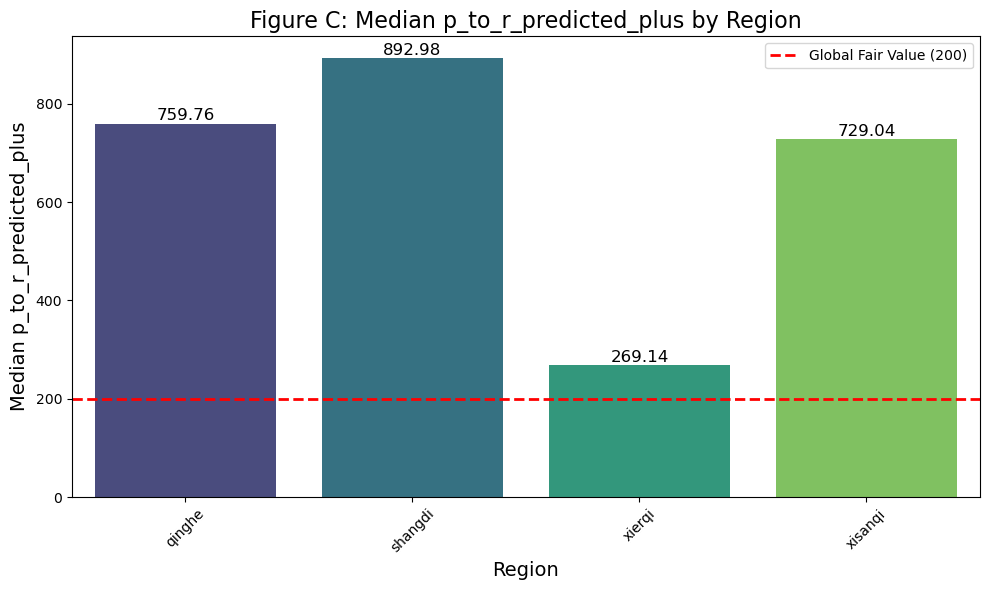

In [10]:
############ 计算地区中位数并画图

# 加载 p_to_r_plus.parquet 文件
p_to_r_plus = pd.read_parquet('p_to_r_plus.parquet')

# 计算每个 region 的 p_to_r_predicted 列的中位数
medians = p_to_r_plus.groupby('region')['p_to_r_predicted_plus'].median().reset_index()

# 查看中位数结果
print(medians)



# 使用 seaborn 绘制 bar plot
plt.figure(figsize=(10, 6))  # 保持图形大小不变
ax = sns.barplot(data=medians, x='region', y='p_to_r_predicted_plus', hue='region', palette='viridis', legend=False)

# 在每个条形顶部添加数字
for p in ax.patches:
    height = p.get_height()  # 获取条形的高度（即中位数值）
    # 在条形顶部添加数字，稍微调整位置使其不重叠
    ax.text(p.get_x() + p.get_width() / 2, height + 0.5,  # 小调整，避免与条形重叠
            f'{height:.2f}',  # 显示两位小数
            ha='center', va='bottom', fontsize=12)  # 水平居中，垂直对齐在顶部

# 添加红色的虚线
ax.axhline(y=200, color='red', linestyle='--', linewidth=2, label='Global Fair Value (200)')

# 添加标题和标签
plt.title('Figure C: Median p_to_r_predicted_plus by Region', fontsize=16)
plt.xlabel('Region', fontsize=14)
plt.legend()
plt.ylabel('Median p_to_r_predicted_plus', fontsize=14)
plt.xticks(rotation=45)  # 让 x 轴标签倾斜以便显示
plt.tight_layout()  # 确保图形不会被截断

# 显示图形
plt.show()

### 2.6 三种统计模式比较

In [207]:
import pandas as pd

In [208]:
# 定义要读取的文件路径
files = [
    'model_Non-linear OLS for price.parquet',
    'model_Non-linear OLS for rent.parquet',
    'model_linear OLS for price.parquet',
    'model_linear OLS for rent.parquet'
]

# 读取并合并所有文件
dfs = [pd.read_parquet(file) for file in files]
reg_results = pd.concat(dfs, ignore_index=True)

# 查看合并后的结果
reg_results.info()
reg_results.head(36)

# 保存合并后的结果（如果需要）
# reg_results.to_parquet('reg_results.parquet', index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Model Name       36 non-null     object 
 1   Variable         36 non-null     object 
 2   Coefficient      36 non-null     float64
 3   P-value          36 non-null     float64
 4   Significance     36 non-null     object 
 5   Sample Size (N)  36 non-null     float64
 6   R-squared        36 non-null     float64
dtypes: float64(4), object(3)
memory usage: 2.1+ KB


,Model Name,Variable,Coefficient,P-value,Significance,Sample Size (N),R-squared
0,Non-linear OLS for price,const,158442.844188,2.922430e-07,***,2227.0,0.435947
1,Non-linear OLS for price,is_xierqi,-82174.164222,2.288415e-34,***,2227.0,0.435947
2,Non-linear OLS for price,is_xisanqi,-73426.357445,2.478011e-34,***,2227.0,0.435947
3,Non-linear OLS for price,is_qinghe,-87910.860558,1.467906e-41,***,2227.0,0.435947
4,Non-linear OLS for price,area,-276.486673,1.370982e-01,Not Significant,2227.0,0.435947
5,Non-linear OLS for price,area_squared,0.903389,4.373317e-02,**,2227.0,0.435947
6,Non-linear OLS for price,log_area,-11006.609953,2.536056e-01,Not Significant,2227.0,0.435947
7,Non-linear OLS for price,area_is_xierqi,717.790200,2.406482e-12,***,2227.0,0.435947
8,Non-linear OLS for price,area_is_xisanqi,515.940193,8.923930e-08,***,2227.0,0.435947
9,Non-linear OLS for price,area_is_qinghe,1106.420497,6.077409e-28,***,2227.0,0.435947


从上述表格可以看出，加入非线性项（如平方项、对数项及交互项）后，模型的拟合优度（R²）显著提高：

1. 对于租金的估计，模型的拟合度提升了**191%**；
2. 对于售价的估计，模型的拟合度提升了**29%**。

这些结果表明，增加非线性项在提升模型估计准确性方面发挥了关键作用。

然而，考虑到引入额外的估计参数会导致自由度的减少，我们有必要探讨这种变化是否会影响模型估计的效率。针对这一问题，我认为，由于样本量较大（去重后的样本数介于2000至2500之间），并且待估参数在扩展后仍保持相对较少（最多13个），因此自由度的减少不会对模型估计的效率产生显著影响。

综上所述，在大样本条件下，加入非线性项能够有效捕捉数据的非线性特征，从而提高模型的预测准确度。而在样本量充足的情况下，参数的增加不会对自由度产生严重威胁，模型的估计结果仍然是可靠的。

因此，对于使用三种不同方法（样本中位数、线性回归估计中位数、非线性回归估计中位数）：
1. 第一种方法本质是使用一个样本代替整体，无法进行统计推断，自然不知道其准确程度如何。
2. 第二、三种方法都是使用回归的手段，通过假设样本分布特征，根据一定规则（最小化标准差平方和），计算出来的样本系数。
3. 区别在于，第二种方法解释变量均为线性，第三种方法解释变量加入非线性项。因此相较于第二种方法，第三种方法通过更为多元的函数形式捕捉到样本数据的变化趋势。
4. 当然，还存在使用分段函数的方法，但根据**RDD**的思路我们可以知道，这两种方法在中心思想上是一致的，同时各具优劣。譬如分段的方法就会面临带宽的选择，函数法就会面临将远离断点的数据纳入考虑的风险。

所以从统计学的角度，我更相信**C**的估计结果，也即：
| C  | region  | p_to_r_predicted_plus |
|----|---------|-----------------------|
| 0  | qinghe  | 761.442802            |
| 1  | shangdi | 890.300920            |
| 2  | xierqi  | 287.274192            |
| 3  | xisanqi | 728.342996            |

附录：A结果
| No. | region  | price_rent_ratio |
|-----|---------|------------------|
| 1   | qinghe  | 951.408085       |
| 2   | shangdi | 793.213804       |
| 3   | xierqi  | 548.225730       |
| 4   | xisanqi | 714.013299       |

附录：B结果
| No. | region  | p_to_r_predicted |
|-----|---------|------------------|
| 1   | qinghe  | 844.010784       |
| 2   | shangdi | 783.792600       |
| 3   | xierqi  | 284.496114       |
| 4   | xisanqi | 641.986094       |
